In [1]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr
import DarkVerse as dv



/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import NoExclusion


# !! handle the star / galaxy separation
## Try with SN-C3 

In [2]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')


# Catalog
fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table
t=join(t,t3,keys='id') 
#t.rename_column('ra_1','ra')
#t.rename_column('dec_1','dec')
t.rename_column('mode_z','z')
t.rename_column('mode_mass','SM')



#!!! remove stars 
t = t[t['kNN_class'] != 2]
# Our main star / galaxy separation method in the DES DF is a kNN classifier, with the catalogue column kNN_CLASS. We should discard objects with values of 2.
# But that won't remove all stars, so we also want to use a compactness cut

# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog



In [3]:
t['kNN_class']

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [4]:
print(t.colnames)

print(type(t))


['id', 'z', 'SM', 'z_pcntiles', 'z_pdf', 'ra', 'dec', 'fof_id', 'fof_size', 'mask_flags', 'flags', 'flagstr', 'badpix_frac', 'psf_g_0', 'psf_g_1', 'psf_T', 'bdf_T', 'bdf_T_err', 'bdf_T_ratio', 'bdf_g_0', 'bdf_g_1', 'bdf_fracdev', 'bdf_fracdev_err', 'tilename', 'EBV_SFD98', 'mask_flags_nir', 'flags_nir', 'flagstr_nir', 'badpix_frac_nir', 'psf_flux_u', 'psf_flux_g', 'psf_flux_r', 'psf_flux_i', 'psf_flux_z', 'psf_flux_J', 'psf_flux_H', 'psf_flux_Ks', 'psf_flux_err_u', 'psf_flux_err_g', 'psf_flux_err_r', 'psf_flux_err_i', 'psf_flux_err_z', 'psf_flux_err_J', 'psf_flux_err_H', 'psf_flux_err_Ks', 'bdf_flux_u', 'bdf_flux_g', 'bdf_flux_r', 'bdf_flux_i', 'bdf_flux_z', 'bdf_flux_J', 'bdf_flux_H', 'bdf_flux_Ks', 'bdf_flux_err_u', 'bdf_flux_err_g', 'bdf_flux_err_r', 'bdf_flux_err_i', 'bdf_flux_err_z', 'bdf_flux_err_J', 'bdf_flux_err_H', 'bdf_flux_err_Ks', 'gap_flux_u', 'gap_flux_g', 'gap_flux_r', 'gap_flux_i', 'gap_flux_z', 'gap_flux_J', 'gap_flux_H', 'gap_flux_Ks', 'gap_flux_err_u', 'gap_flux_err_

In [5]:
print(t['psf_mag_dered_calib_i'])

psf_mag_dered_calib_i
---------------------
   24.334646753542877
   25.360745915348502
   20.716085898141817
    25.25089804540787
   25.648298035751793
   23.180468003033788
   26.035623081267012
   22.297118410980847
   22.524811936700956
   23.632215793729827
                  ...
   24.942420042010042
   25.939419676484174
     25.6943492680788
   26.387592254522847
   25.076662828340474
   26.116525480847038
    26.06020743147967
    26.10806940304986
   24.004612517723412
   26.005863658511156
Length = 314615 rows


In [6]:
delta_mag = t['bdf_mag_dered_calib_i'] - t['psf_mag_dered_calib_i']


In [7]:
print(len(delta_mag ) )
print(len(t['bdf_mag_dered_calib_i'] ) )

314615
314615


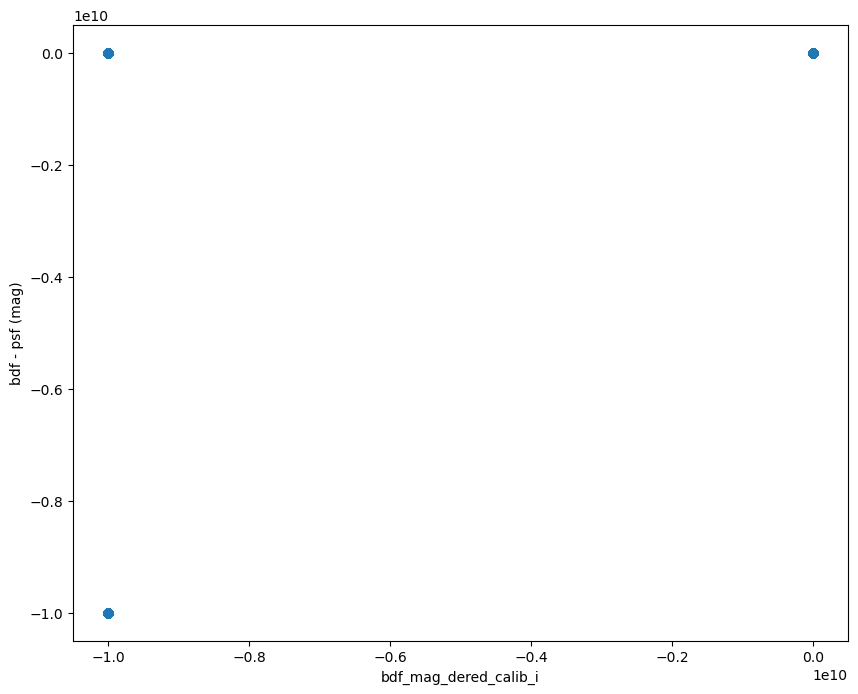

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(t['bdf_mag_dered_calib_i'], delta_mag)
plt.xlabel('bdf_mag_dered_calib_i')
plt.ylabel('bdf - psf (mag)')
plt.show()

### ^ you can see that galaxies tend to have negative values in the magnitude difference axis (they're brighter in the bulge+disk model fit than PSF fit photometry) and stars have values ~0. So we want to define a cut in bdf - psf mag that removes compact objects that are not flagged by kNN_CLASS. 

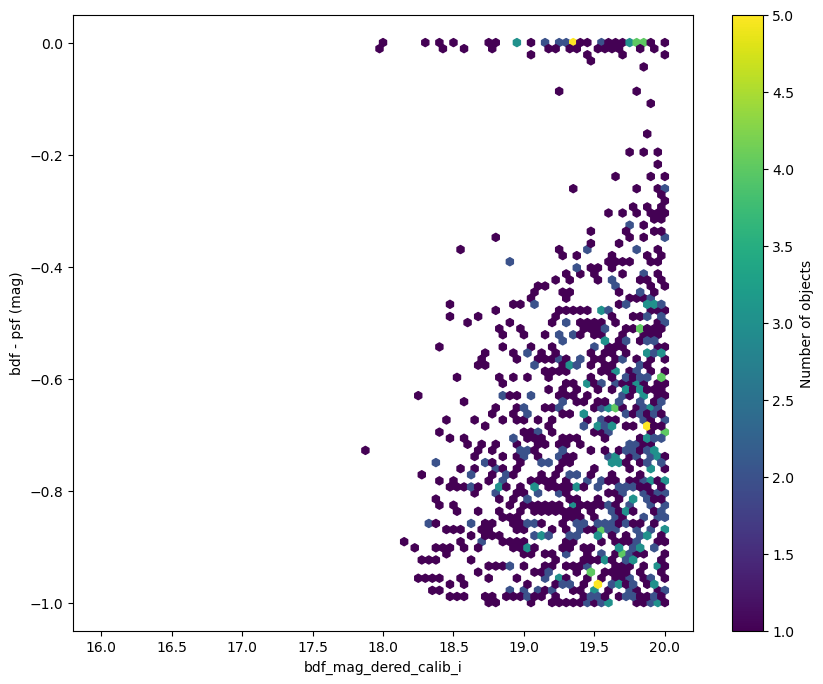

In [9]:
plt.figure(figsize=(10,8))
plt.hexbin( t['bdf_mag_dered_calib_i'], delta_mag, gridsize=80, cmap='viridis', mincnt=1, extent=(16,20, -1,0))
plt.colorbar(label='Number of objects')
plt.xlabel('bdf_mag_dered_calib_i')
plt.ylabel('bdf - psf (mag)')
plt.show()



In [10]:
print(len(np.where((t['bdf_mag_dered_calib_i']<22) & (delta_mag > -0.02))[0]))

661


In [11]:
# Check flagged objects
flagged_mask = (t['flags'] > 0) | (t['flags_nir'] > 0)  # flags>0 or flags_nir>0 

n_flagged = np.sum(flagged_mask)
n_total = len(t)
# what fraction of objects have flags>0 or flags_nir>0 after cross-matching with the masked cat
fraction_flagged = n_flagged / n_total

print(f"Number of objects flagged: {n_flagged}/{n_total}")
print(f"Fraction of flagged objects: {fraction_flagged:.3%}")


Number of objects flagged: 3204/314615
Fraction of flagged objects: 1.018%


#### If it's a small fraction (a few percent), then we can exclude them. We might need to anyway, they might not have valid values for the fluxes etc., so then it's just good to know how many there are. In the worst case we can run the measurements with and without them to test the sensitivity to that. Some of the objects are flagged due to fitting failures, and the risk is that those are more common in densely-populated regions, which is obviously going to affect our clustering measurements.

In [12]:
z_min, z_max = 0.3, 0.6
SM_min, SM_max = 10, 12.5
# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}


In [13]:
sub1 = dv.Selection(t,randoms,z_min,z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended


/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/home/astro/manasoi7/.conda/envs/project/lib/python3.12/site-packages/halomod/halo_model.py:784: UserWarning: You are using an un-normalized mass function and bias function pair.Bias Tinker10 has the following paired HMF model: (). Matter correlations are not well-defined.
  tools.norm_warn(self)


<>:37: SyntaxWarning: invalid escape sequence '\i'
<>:37: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2234126/1639475363.py:37: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)


HOD fit results: M_min = 10^12.25, M_1 = 10^13.59, alpha = 1.14


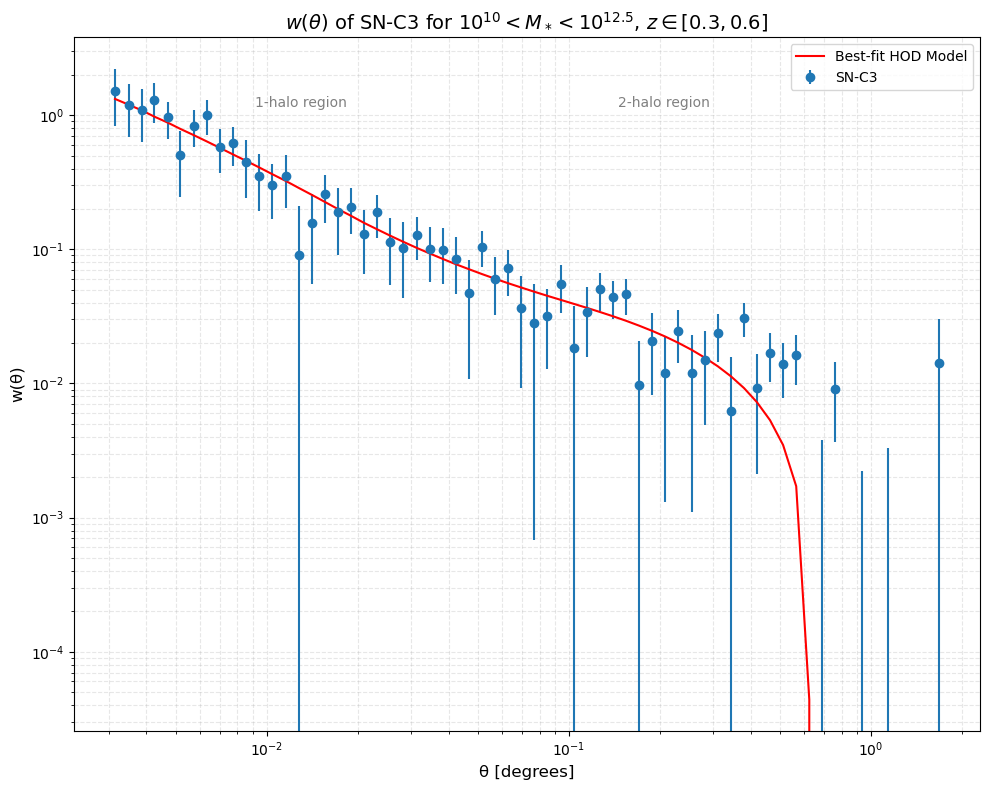

In [14]:

# Fit HOD with custom bounds
#hod_params, pcov = sub1.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds = ([11.0*1e-7, 12.5, 0.99], [14.5*1e-7, 15.5, 1.01]) # fix alpha to 1
hod_params, pcov = sub1.fit_hod(p0=[12.3*1e-7, 13.5, 1.0]) 


results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min*1e7:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']

# Model prediction with best-fit parameters
w_model = sub1.hod_model(logM_min *1e7, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3')
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')

#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')
#plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [{z_min},{z_max}]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')

plt.savefig(f"wtheta_SN_C3_HOD_SM_{SM_min}_{SM_max}_{z_min}_{z_max}.png")

plt.tight_layout()
plt.show()

In [15]:
def load_and_clean_catalog(path, compactness_cut=0):
    """
    Read a FITS catalog and apply star/galaxy separation and flag cleaning.

    """
    cat = Table.read(path)

    # Remove stars 
    if 'kNN_class' in cat.colnames:
        cat = cat[cat['kNN_class'] != 2]

    # Compactness cut: Δm = bdf - psf 
    bdf_col = 'bdf_mag_dered_calib_i'
    psf_col = 'psf_mag_dered_calib_i'
    if bdf_col in cat.colnames and psf_col in cat.colnames:
        delta_mag = cat[bdf_col] - cat[psf_col]
        cat = cat[delta_mag < compactness_cut]

    return cat

def exclude_flagged_objects(cat):
    """
    Exclude objects with flags > 0 or flags_nir > 0.

    """
    flagged_mask = np.zeros(len(cat), dtype=bool)
    if 'flags' in cat.colnames:
        flagged_mask |= cat['flags'] > 0
    if 'flags_nir' in cat.colnames:
        flagged_mask |= cat['flags_nir'] > 0

    return cat[~flagged_mask]

fits_file_path = os.path.join(thesis_path, "DES_DF_SN-C3_sbi_output.fits")
t = load_and_clean_catalog(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")
t3 = load_and_clean_catalog(masked_file_path)
t = join(t, t3, keys='id')
t.rename_column('mode_z', 'z')
t.rename_column('mode_mass', 'SM')
t = exclude_flagged_objects(t)

fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits")
randoms = load_and_clean_catalog(fits_random)
randoms = exclude_flagged_objects(randoms)

print(f"Cleaned science catalog: {len(t)} objects")
print(f"Cleaned random catalog: {len(randoms)} objects")

Cleaned science catalog: 271783 objects
Cleaned random catalog: 13402307 objects


# Now all my DF DES catalogues

In [16]:
%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)